# Segmentation 
First of all try UNet

In [1]:
# check if this notebook called from main one
try: IS_MAIN
except: IS_MAIN = False

In [2]:
# setup necessary parameters
if IS_MAIN:
    print('Segmentation mode: MAIN')    
    lr = 1e-4
    n_epochs = 5
else:
    print('Segmentation mode: STANDALONE')
    lr = 1e-5
    n_epochs = 50
    
test_folder = 'data/transforms/segmentation/test'
train_folder = 'data/transforms/segmentation/train'
validation_folder = 'data/transforms/segmentation/validation'   

Segmentation mode: STANDALONE


In [3]:
# Get Dataloaders:
# test_loader, train_loader, validation_loader
print('Creating Dataset and Dataloader.')
%run '3.2.DataLoader.ipynb'

Creating Dataset and Dataloader.
DataLoader mode: STANDALONE


In [42]:
import torch
def get_segmentation_model():
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                           in_channels=3, out_channels=1, init_features=32, pretrained=True)
    return model
print('Loading model.')
model = get_segmentation_model()

Loading model.


Using cache found in /home/ivan/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [43]:
import numpy as np

def make_train_step(model, loss_fn, optimizer):
    def train_step(x,y):
        # set model to train mode
        model.train()
        # make predictions
        yhat = model(x)
        #compute loss
        y = y.to(device, dtype=torch.float32)
        loss = loss_fn(yhat, y)
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
    return train_step

def make_val_step(model, loss_fn):
    def val_step(x,y):
        # set model to evaluation mode
        model.eval()
        # make prediction
        yhat = model(x)
        # compute loss
        val_loss = loss_fn(yhat, y)
        return val_loss.item()
    return val_step

def train(model, train_loader, n_epochs, optimizer, loss_fn, device, val_loader=None):
    model.to(device)
    
    train_step = make_train_step(model, loss_fn, optimizer)
    val_step = make_val_step(model, loss_fn)
    
    history = {'loss': [], 'val_loss': []}

    train_len = len(train_loader)
    val_len = len(validation_loader)
    
    for epoch in range(n_epochs):
        for i, sample in enumerate(train_loader):
            image, mask = sample['image'].to(device), sample['mask'].to(device)
            
            loss = train_step(image, mask)
            
            history['loss'] += [loss]
            
        if val_loader:
            with torch.no_grad():
                for i, sample in enumerate(val_loader):
                    image, mask = sample['image'].to(device), sample['mask'].to(device)
                    
                    val_loss = val_step(image, mask)
                    
                    history['val_loss'] += [val_loss]
                    
        epoch_loss = np.mean(history['loss'][epoch*train_len:(epoch+1)*train_len])
        epoch_val_loss = np.mean(history['val_loss'][epoch*val_len:(epoch+1)*val_len])
        
        print('Epoch[{:2}/{:2}] loss: {:3.4f}, val_loss: {:3.4f}'
              .format(epoch+1, n_epochs, epoch_loss, epoch_val_loss))
                
    return history

In [44]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.BCELoss()

# Train the model
history = train(model, train_loader, n_epochs, optimizer, loss_fn, device, validation_loader)
print('Training done.')

Epoch[ 1/50] loss: 5.2072, val_loss: 4.7654
Epoch[ 2/50] loss: 4.0508, val_loss: 3.9457
Epoch[ 3/50] loss: 3.6164, val_loss: 3.2414
Epoch[ 4/50] loss: 3.3433, val_loss: 2.8535
Epoch[ 5/50] loss: 3.1550, val_loss: 2.5839
Epoch[ 6/50] loss: 2.9774, val_loss: 2.3878
Epoch[ 7/50] loss: 2.7991, val_loss: 2.1867
Epoch[ 8/50] loss: 2.6248, val_loss: 1.9934
Epoch[ 9/50] loss: 2.4615, val_loss: 1.8121
Epoch[10/50] loss: 2.3145, val_loss: 1.6445
Epoch[11/50] loss: 2.1794, val_loss: 1.4930
Epoch[12/50] loss: 2.0591, val_loss: 1.3697
Epoch[13/50] loss: 1.9530, val_loss: 1.2745
Epoch[14/50] loss: 1.8577, val_loss: 1.1996
Epoch[15/50] loss: 1.7728, val_loss: 1.1419
Epoch[16/50] loss: 1.6974, val_loss: 1.0935
Epoch[17/50] loss: 1.6299, val_loss: 1.0545
Epoch[18/50] loss: 1.5676, val_loss: 1.0225
Epoch[19/50] loss: 1.5103, val_loss: 0.9973
Epoch[20/50] loss: 1.4575, val_loss: 0.9736
Epoch[21/50] loss: 1.4080, val_loss: 0.9537
Epoch[22/50] loss: 1.3608, val_loss: 0.9385
Epoch[23/50] loss: 1.3153, val_l

In [45]:
print('Saving model.') 
torch.save(model.state_dict(), './exp/models/unet_{}_{}.pth'.format(len(train_loader), n_epochs))

Saving model.


In [49]:
print('Generating masks for train data.')

from torchvision.transforms import ToPILImage
untransform = ToPILImage()

file_index = 0

with torch.no_grad():
    model.eval()
    for i, sample in enumerate(train_loader):
        image, mask = sample['image'].to(device), sample['mask'].to(device)
        pred_mask = model(image)
        pred_mask = pred_mask.cpu()
        
        batch_size = sample['image'].shape[0]

        for b in range(batch_size):
            msk = pred_mask[b]
            msk = untransform(msk)
            filename = train_loader.dataset.images_paths[file_index].split('/')[-1]
            msk.save('./exp/predicted_masks/'+filename)
            file_index += 1
        
print('done.')

Generating masks for train data.
done.


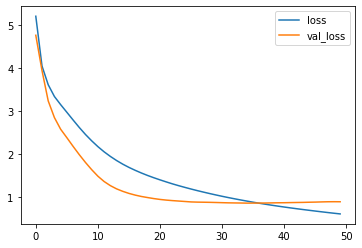

In [47]:
if not IS_MAIN:
    val_len = len(validation_loader)
    train_len = len(train_loader)
    mean_loss = [np.mean(history['loss'][i*train_len:(i+1)*train_len]) for i in range(n_epochs)]
    mean_val_loss = [np.mean(history['val_loss'][i*val_len:(i+1)*val_len]) for i in range(n_epochs)] 
    import matplotlib.pyplot as plt
    plt.plot(mean_loss, label='loss')
    plt.plot(mean_val_loss, label='val_loss')
    plt.legend()
    plt.show()